In [1]:
import math
import gzip
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import itertools
from functools import lru_cache
from itertools import chain, zip_longest
import pickle, random
import copy
from glob import glob
from pprint import pprint
from copy import deepcopy
import pickle as pck
from functools import cache
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from fractions import Fraction

from utils import *

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

title_font = 22
subplot_font = 14
plot_font = 18
legend_font = 16
col_font = subplot_font + 4

matplotlib.rc('font', size=subplot_font)

ylim_pad_factor = 0.05

# Same colours as mod-mini paper
scheme_to_color = {
    'Random minimizer': "orange",
    'DoubleDecyclingMinimizer': "black",
    'Miniception': "#00dd00",
    'Mod-minimizer': "blue",
}
scheme_names = [
    'Random minimizer',
    'DoubleDecyclingMinimizer',
    'Miniception',
    'Mod-minimizer',
]

In [2]:
# Read forward densities
fwd_wksigma_to_dens = {}
for pck_file in glob("fwd/dens/*.pck"):
    with open(pck_file, 'rb') as pck_in:
        fwd_wksigma_to_dens.update(pck.load(pck_in))
for sigma, solcount in sorted(Counter(sigma for w, k, sigma in fwd_wksigma_to_dens.keys()).items()):
    print(f"sigma={sigma} --> {solcount} solutions")

sigma=2 --> 38 solutions
sigma=3 --> 14 solutions
sigma=4 --> 8 solutions


In [3]:
# Read local densities
local_wksigma_to_dens = {}
for pck_file in glob("local/dens/*.pck"):
    with open(pck_file, 'rb') as pck_in:
        local_wksigma_to_dens.update(pck.load(pck_in))
for sigma, solcount in sorted(Counter(sigma for w, k, sigma 
                                      in local_wksigma_to_dens.keys()).items()):
    print(f"sigma={sigma} --> {solcount} solutions")

sigma=2 --> 10 solutions
sigma=3 --> 1 solutions
sigma=4 --> 1 solutions


In [4]:
# Read local densities
local_wksigma_to_dens_unfinished = {}
for pck_file in glob("local/dens/gap/*.pck"):
    with open(pck_file, 'rb') as pck_in:
        local_wksigma_to_dens_unfinished.update(pck.load(pck_in))
for sigma, solcount in sorted(Counter(sigma for w, k, sigma 
                                      in local_wksigma_to_dens_unfinished.keys()).items()):
    print(f"sigma={sigma} --> {solcount} solutions")

sigma=2 --> 11 solutions
sigma=3 --> 1 solutions


In [5]:
# Uniform plotting style
def style(ax, w=None, sigma=None, k=1, title=None, ymax_pad_factor=ylim_pad_factor, miniception=None, ilp=False):
    ax.grid(False)
    ax.grid(True, axis="x", color='#ccc',linewidth=0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    if w:
        ax.spines['bottom'].set_visible(False)
        ax.set_ylim(ymin=1/w * (1-ylim_pad_factor), ymax=(1+ymax_pad_factor)*2/(w+1))

        rnge = 2/(w+1) - 1/w
        dst = rnge/6
        
        
        ticks = [1/w]
        if sigma and ilp:
            extra = float(aperiodic_bound_suff(w,k,sigma))
            ticks.append(extra)
        else:
            ticks.append(2/(w+1))

        tick_range = ticks[-1] - ticks[0]
        ticks.extend([ticks[0] + tick_range/2])
        # extra = ragnar_WABI_LB(w, k)
        # if extra > 1/w + dst:
        #     ticks.append(extra)
        # ticks.append((ticks[0] + ticks[1]) / 2)
        if miniception:
            extra = miniception
            if all(abs(extra - t) > dst for t in ticks):
                ticks.append(extra)
        ax.set_yticks(ticks)
    else:
        ax.spines['bottom'].set_visible(True)
        ax.set_ylim(ymin=0, ymax=0.8)
        w=2
        if sigma:
            g_sigma = float(aperiodic_bound(w=2, k=1, sigma=sigma))
            ax.set_yticks([0, g_sigma/2, g_sigma])
        else:
            ax.set_yticks([0, 1/4, 1/2, 2/(w+1)])

    if title:
        ax.set_title(title, loc="right", y=1.0, pad=-14, fontsize=subplot_font+1)

        
def row_label(ax, label):
    ax.annotate(label, xy=(0, 0.5), xytext=(0,0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90)

def col_label(ax, label):
    ax.annotate(label, xy=(0.5, 1), xytext=(0, 5),
            xycoords='axes fraction', textcoords='offset points',
            size='large', ha='center', va='baseline')

def hide_x_ticks(ax):
    ax.tick_params( axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off

def hide_y_ticks(ax):
    ax.tick_params( axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,      # ticks along the bottom edge are off
                    right=False,         # ticks along the top edge are off
                    labelleft=False) # labels along the bottom edge are off


# lower bound style
# TODO: separate g and g'
lbs = {
    'linestyle': 'solid',
    'linewidth': 1.5,
}

lower_bounds = [
    (lambda w,k,sigma: 1/w, "$\\frac{1}{w}$", 'black'),
    # (lambda w,k,sigma: ragnar_WABI_LB(w,k), "$\\frac{1.5}{w+k-0.5}$", 'slategray'),
    # (lambda w,k,sigma: ragnar_ceil_LB(w, k), "$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", "royalblue"),
    # (aperiodic_bound, "$g_\\sigma$", "purple"),
    (aperiodic_bound_suff, "$g^\\prime_\\sigma$", "blue"),
]
    

def plot_lower_bounds(ax, *, w_range=None, k_range=None, w=None, k=None, sigma, ilp=False, subset=False):
    # clone style
    my_lbs = lbs.copy()
    if subset:
        my_lower_bounds = [lower_bounds[-1], lower_bounds[0]]
        my_lbs['linewidth'] = 1.5
    else:
        my_lower_bounds = lower_bounds
        
    if k:
        for (f, label, color) in my_lower_bounds:
            ax.plot(w_range, [f(w,k,sigma) for w in w_range], label=label, color=color, **my_lbs)
    else:
        for (f, label, color) in my_lower_bounds:
            ax.plot(k_range, [f(w,k,sigma) for k in k_range], label=label, color=color, **my_lbs)

    if ilp:
        opt_k = []
        opt_dens = []
        opt_color = []
        if k:
            for w in w_range:
                if (w, k, sigma) in fwd_wksigma_to_dens:
                    opt_k.append(w)
                    opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
                    opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")
        else:
            for k in k_range:
                if (w, k, sigma) in fwd_wksigma_to_dens:
                    opt_k.append(k)
                    opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
                    opt_color.append("orange" if not aperiodic_bound_suff(w, k, sigma) == fwd_wksigma_to_dens[(w, k, sigma)] else "black")
        ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=25, zorder=100)
        ax.set_ylim(ymax=(1+ylim_pad_factor)*opt_dens[0])


In [10]:

ax_width = 3
ax_height = 3
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(12)
fig.subplots_adjust(wspace=.25)

w_range = list(range(3,6))
sigma = 2
for idx, w in enumerate(w_range):
    k_range = list(range(1, 15))
    ax = axs[idx, 0]
    style(ax, w, sigma, title=f"$w={w}$  ", ilp=True)
    plot_lower_bounds(ax, k_range=k_range, w=w, sigma=sigma, ilp=True)
    
    if w != w_range[-1]:
        hide_x_ticks(ax)
    else:
        ax.set_xlabel("$k$")

sigma_range = list(range(2, 5))
w = 2
for idx, sigma in enumerate(sigma_range):
    k_range = list(range(1, 15))
    ax = axs[idx, 1]
    style(ax, w, sigma, title=f"$\\sigma={sigma}$  ", ilp=True)
    plot_lower_bounds(ax, k_range=k_range, w=w, sigma=sigma, ilp=True)

    if sigma != sigma_range[-1]:
        hide_x_ticks(ax)
    else:
        ax.set_xlabel("$k$")

k=1
for idx, sigma in enumerate(sigma_range):
    w_range = list(range(2, 13))
    ax = axs[idx, 2]
    style(ax, None, sigma, title = f"$\\sigma={sigma}$  ", ilp=True)
    plot_lower_bounds(ax, w_range=w_range, k=k, sigma=sigma, ilp=True)

    if sigma != sigma_range[-1]:
        hide_x_ticks(ax)
    else:
        ax.set_xlabel("$w$")


col_label(axs[0][0], f"$\\sigma=2$")
col_label(axs[0][1], f"$w=2$")
col_label(axs[0][2], f"$k=1$")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.045, 0.5), loc='center right', prop={'size': legend_font}, ncols=1)
fig.supylabel("Density", x=0.04, fontsize=plot_font)
fig.suptitle("Density lower bounds and ILP results for forward schemes", fontsize=title_font)
fig.savefig(f"media/bound-fwd-grid.svg", bbox_inches='tight')
#fig.show()
plt.close(fig)


In [11]:
# Density table

prev_sigma = 0
sigma_to_count = {sigma: sum(s == sigma for (w, k, s) in fwd_wksigma_to_dens) for sigma in range(5)}
from pathlib import Path

data = ''

for (w, k, sigma), fwd_dens in sorted(fwd_wksigma_to_dens.items(), key=lambda pair: (pair[0][2], pair[0][0], pair[0][1])):
    line = ""
    if sigma != prev_sigma:
        if data:
            path = Path(f'media/table_sigma{prev_sigma}.tex')
            path.write_text(data)
            data = ''
        prev_w = 0
    if w != prev_w:
        data += "\\midrule\n"
    prev_w = w
    line += f" ${w},{k}$"
    
    lb_float = aperiodic_bound_suff(w, k, sigma)
    lb_frac = Fraction(lb_float)
    line += f"& {float(lb_frac):.3f} & {str(lb_float):<9} "

    if lb_frac == fwd_dens:
        line += "& \\multicolumn{2}{c}{$=$} "
    else:
        line += f"& {float(fwd_dens):.3f} & {str(fwd_dens):<9} "

    if w == 2:
        line += "& \\multicolumn{2}{c}{$=$} "
    elif (w, k, sigma) in local_wksigma_to_dens:
        local_dens = local_wksigma_to_dens[(w, k, sigma)]
        if local_dens == fwd_dens:
            line += "& \\multicolumn{2}{c}{$=$} "
        else:
            line += f"& {float(local_dens):.3f} & {str(local_dens):<9} "
    elif (w, k, sigma) in local_wksigma_to_dens_unfinished:
        local_dens = local_wksigma_to_dens_unfinished[(w, k, sigma)]
        if local_dens < fwd_dens:
            line += f"&\\hspace{{-0.7em}}$\\leq${float(local_dens):.3f} & {str(local_dens):<9} "
        else:
            line += f"& {'':<5} & {'':<9} "
    else:
        line += f"& {'':<5} & {'':<9} "
        
    line += " \\\\\n"
    data += line
    prev_sigma = sigma

path = Path(f'media/table_sigma{prev_sigma}.tex')
path.write_text(data)

677

In [12]:
def read(file):
    if file.endswith(".gz"):
        with gzip.open(file, 'rt', encoding='UTF-8') as f:
            data = json.load(f)
    else:
        with open(file, 'r') as f:
            data = json.load(f)
        
    df = pd.json_normalize(data)

    # Rename column 'tp.minimizer_type' to 'Minimizer type'
    df = df.rename(columns={'tp.minimizer_type': 'Minimizer type'})
    # In type column replace minizer value with random minimizer.
    df['Minimizer type'] = df['Minimizer type'].replace('Minimizer', 'Random minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('LrMinimizer', 'LR-minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('ModMinimizer', 'Mod-minimizer')
    df['Minimizer type'] = df['Minimizer type'].replace('MiniceptionNew', 'Modified miniception')

    df['param'] = df['tp.k0'].fillna(0) #+ df['tp.r'].fillna(0)

    return df

In [13]:
all_sigmas = [2, 4, 256]
df_by_sigma = []
for sigma in all_sigmas:
    datafile = f"data/practical-s{sigma}.json.gz"
    df_by_sigma.append(read(datafile))

df_random = pd.concat(df_by_sigma).sort_values("k")
df_random["text"] = "Random"

datafile = f"data/practical-chm13Y.json.gz"
df_chm13 = read(datafile)
df_chm13["text"] = "ChrY"

df = pd.concat([df_random, df_chm13]).sort_values("k")
all_window_sizes = sorted(df["w"].unique())
all_scheme_names = sorted(df["Minimizer type"].unique())
pprint(sorted(all_scheme_names))

df_schemes = df[df["Minimizer type"].isin(scheme_names)].sort_values("k")

['DoubleDecyclingMinimizer', 'Miniception', 'Mod-minimizer', 'Random minimizer']


In [14]:
sigma = 4
w = 5
k = 31
text = "Random"
for w, k in [(5, 31), (12, 20), (19, 19)]:
    df_comp = df_schemes[
    (df_schemes["w"] == w) 
    & (df_schemes["sigma"] == sigma) 
    & (df_schemes["k"] == k)
    & (df_schemes["text"] == text)]
    best = df_comp.loc[df_comp["density"].idxmin()]
    best_density = best["density"]
    best_scheme = best["Minimizer type"]
    lower_bound = aperiodic_bound_suff(w, k, sigma)
    
    print(f"For w={w}, k={k}, {best_scheme} performed best w/ a density of {best_density:.4f}.")
    print(f"Gap decreased from {100*(best_density-(1/w))/(1/w):.2f}% --> {100*(best_density-lower_bound)/lower_bound:.2f}%")
    print()

For w=5, k=31, Mod-minimizer performed best w/ a density of 0.2257.
Gap decreased from 12.83% --> 1.55%

For w=12, k=20, Mod-minimizer performed best w/ a density of 0.1199.
Gap decreased from 43.91% --> 10.93%

For w=19, k=19, DoubleDecyclingMinimizer performed best w/ a density of 0.0790.
Gap decreased from 50.09% --> 2.69%



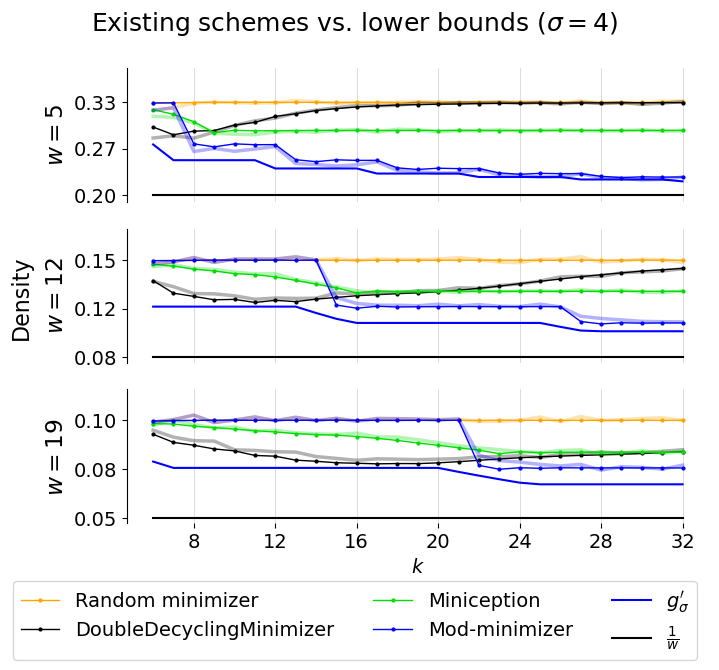

In [15]:
w_range = [5, 12, 19]
k_min, k_max = 6, 32
sigma = 4

title_font = 18
subplot_font = 14
plot_font = 16
legend_font = 14

fig, axs = plt.subplots(nrows=len(w_range), ncols=1)
fig.set_figheight(6)
fig.set_figwidth(7.5)

for idx, w in enumerate(w_range):
    df_sub = df_schemes[(df_schemes["w"] == w) & (df_schemes["sigma"] == sigma)]
    ax = axs[idx]
    style(ax, w, sigma, k=6 if w==5 else 8, ymax_pad_factor=0.15)
    
    for scheme in scheme_names:
        for text in ["Random", "ChrY"]:
            df_this = df_sub[(df_sub["Minimizer type"] == scheme) & (df_sub["text"] == text) & (k_min <= df_sub['k']) & (df_sub['k'] <= k_max)]
            y_vals = df_this["density"]

            if df_this.empty:
                continue
                
            if text == "Random":
                ax.plot(df_this["k"], y_vals, label=scheme, color=scheme_to_color[scheme], marker='o', markersize=2, lw=1)
            else:
                ax.plot(df_this["k"], y_vals, color=scheme_to_color[scheme], alpha=0.3, lw=2.5)

    # Plot lower bounds
    k_range = list(range(k_min, k_max+1))
    plot_lower_bounds(ax, k_range=k_range,w=w,sigma=sigma, subset=True)

    # Pad upper and lower limits
    ax.xaxis.set_major_locator(MaxNLocator(nbins=8))

    # Turn off x-axis items for all axes except last
    if w != w_range[-1]:
        hide_x_ticks(ax)
    else:
        ax.set_xlabel('$k$')

# Add labels to rows
for ax, w in zip(axs, w_range):
    row_label(ax, f"$w={w}$")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.12), prop={'size': legend_font}, ncols=3)
#fig.supxlabel("$k$", y=.03, fontsize=plot_font)
fig.suptitle(f"Existing schemes vs. lower bounds ($\\sigma={{{sigma}}}$)", fontsize=title_font)
fig.supylabel(f"Density", x=0.04, fontsize=plot_font)
fig.tight_layout()

fig.savefig(f"media/benchmark-sigma{sigma}-density.svg", bbox_inches='tight')
#fig.show()
#plt.close(fig)


In [16]:
w_range = [2, 5, 12, 19, 50]
sigma_range = all_sigmas
k_min, k_max = 6, 64
plot_ratio = False

title_font = 23
subplot_font = 14
plot_font = 18
legend_font = 14

fig, axs = plt.subplots(nrows=len(w_range), ncols=len(all_sigmas))
fig.set_figheight(11)
fig.set_figwidth(12)
text = "Random"

for idx_sigma, sigma in enumerate(sigma_range):
    for idx_w, w in enumerate(w_range):
        df_sub = df_schemes[(df_schemes["w"] == w) & (df_schemes["sigma"] == sigma) & (df_schemes.text == 'Random')]
        ax = axs[idx_w, idx_sigma]
        vals = df_sub[(df_sub['Minimizer type'] == 'Miniception') & (df_sub.k == df.k.max())]
        tick_k = 8
        if w == 2:
            tick_k = 6
        if w == 50:
            tick_k = 17
        style(ax, w, sigma, k=tick_k)#, miniception=vals.density.iloc[0])

        for scheme in scheme_names:
            df_this = df_sub[(df_sub["Minimizer type"] == scheme) & (df_sub["text"] == text) & (k_min <= df_sub['k']) & (df_sub['k'] <= k_max)]
            y_vals = df_this["density"]

            if text == "Random":
                ax.plot(df_this["k"], y_vals, label=scheme, color=scheme_to_color[scheme], marker='o', markersize=2, lw=1)
            else:
                ax.plot(df_this["k"], y_vals, color=scheme_to_color[scheme], alpha=0.2, lw=2)

        # Plot lower bounds
        k_range = list(range(k_min, k_max+1))
        plot_lower_bounds(ax, k_range=k_range,w=w,sigma=sigma, subset=True)

        # Pad upper and lower limits
        ax.xaxis.set_major_locator(MaxNLocator(nbins=8))

        # Turn off x-axis items for all axes except last
        if w != w_range[-1]:
            hide_x_ticks(ax)
       
        # Turn off y-axis items for all axes except left
        if sigma != sigma_range[0] and not plot_ratio:
            hide_y_ticks(ax)

        if sigma == sigma_range[1] and w == w_range[-1]:
            ax.set_xlabel("$k$", fontsize=plot_font)

# Add labels to rows and columns
for ax, w in zip(axs[:,0], w_range):
    row_label(ax, f"$w={w}$")
    
for ax, sigma in zip(axs[0], all_sigmas):
    col_label(ax, f"$\\sigma={sigma}$")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.07), loc='lower center', prop={'size': legend_font}, ncols=3)
fig.suptitle(f"Existing schemes vs. lower bounds", fontsize=title_font)
fig.supylabel(f"Density", x=0.02, fontsize=plot_font)
fig.tight_layout()

fig.savefig(f"media/benchmark-grid-density.svg", bbox_inches='tight')
#fig.show()
plt.close(fig)